<a href="https://colab.research.google.com/github/manuelescola/myprojects/blob/main/01_XGBoost_client_chunk_rate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

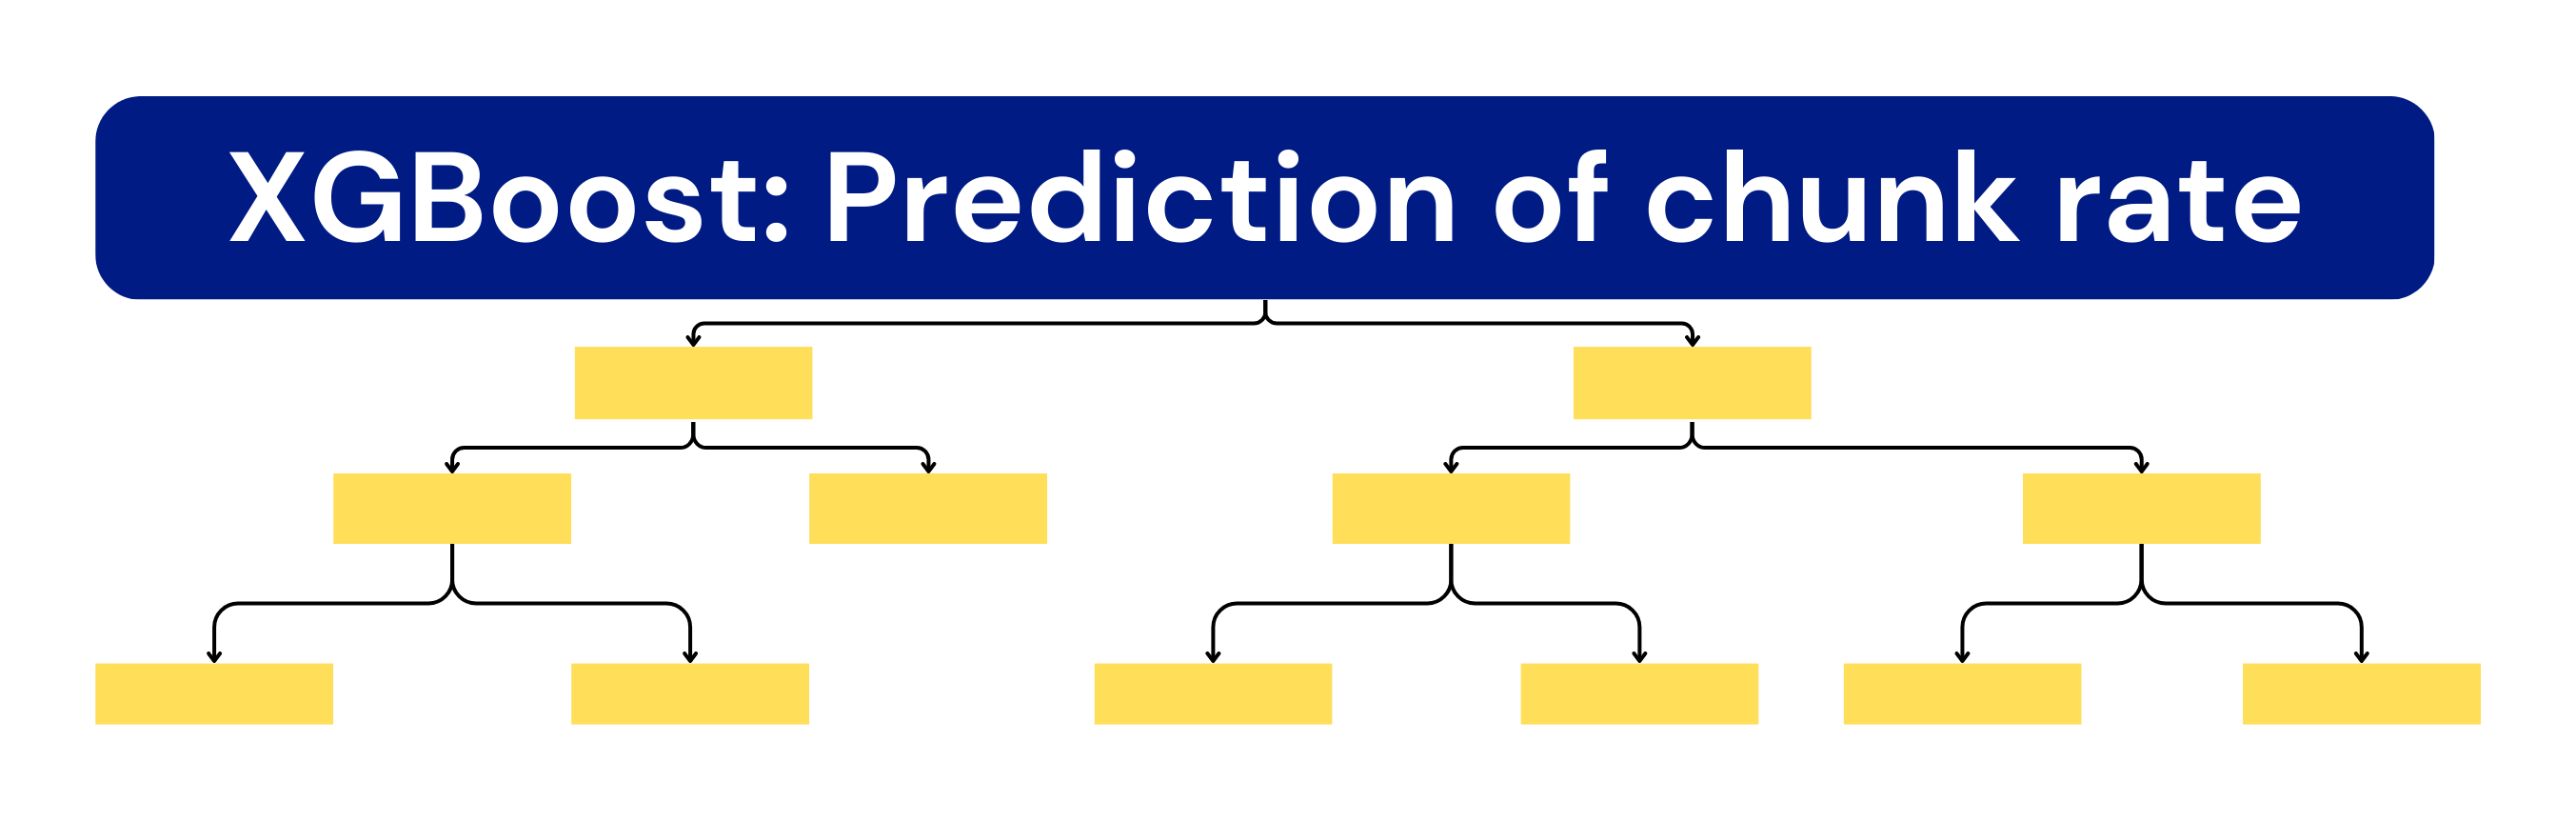

_Note: This notebook has been designed to be run in Google Collab. If run it locally or in other platforms, please update how the dataset is loaded into the notebook._

# 1. Introduction

Client churn rate refers to the percentage of customers who stop using a company's products or services over a given period of time. It is a critical metric for any business because losing customers is not only costly in terms of revenue, but it also affects the company's reputation and future growth potential. Therefore, being able to predict which customers are at risk of churning allows a business to take proactive measures to retain them and prevent further attrition.

This notebook explores the use of XGBoost models in predicting customer churn in an imbalanced dataset. Imbalanced datasets are common in real-world scenarios where the number of churned customers is significantly lower than those who stay. The notebook investigates how different hyperparameters of the XGBoost model, such as the `maximum depth` or the `learning rate`, affect the model's performance in terms of precision and recall. In particular, the notebook pays special attention to the effect of the `scale_pos_weight` hyperparameter to penalise the predictions of the majority class. The notebook also provides insights about how to balance the trade-off between precision and recall to achieve the best possible performance in predicting customer churn depending on the business objectives.

# 2. Setting up the notebook

In [ ]:
# Installing libraries if they have not been installed before
!pip freeze | grep xgboost || pip install xgboost
!pip freeze | grep scikit-learn || pip install scikit-learn

# Importing libraries
import pandas as pd
import numpy
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm

# This allows to show all columns in the dataframe during the cleaning part
pd.options.display.max_columns = None

xgboost==1.7.5
scikit-learn==1.2.2


# 3. Data preprocessing

## 3.1. Importing dataset

First we import the CSV file, assign it to a dataframe (df_original) and create a copy of it (df).

In [ ]:
%%capture 
! gdown --id 1UPZihePiBEY61DHSjz9qoPuHJT8rP8Sy

In [ ]:
df_original = pd.read_csv('Telco_customer_churn.csv')

In [ ]:
df = df_original.copy()

In [ ]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## 3.2. Cleaning the dataset

We first replace the whitespaces in the names of the columns of the dataset.

In [ ]:
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
df.columns[5:10]  #showing some names

Index(['Zip_Code', 'Lat_Long', 'Latitude', 'Longitude', 'Gender'], dtype='object')

We drop some of the last variables, since they contain information only about those who left the company (and therefore cannot be used for a new customer to predict if he will left the company). Note that we do not drop `Churn_Value` because it will be the variable we will try to predict.

In [ ]:
to_drop = ['Churn_Label', 'Churn_Score', 'CLTV', 'Churn_Reason']
df.drop(to_drop, axis=1, inplace=True)

Now we check the value counts for each variable to see which ones only contain one value.

In [ ]:
not_diverse = []
for name in df.columns:
  if len(df[name].unique())==1:
    not_diverse.append(name)
print(f'The columns with only one value are: {not_diverse}')

The columns with only one value are: ['Count', 'Country', 'State']


In [ ]:
df.drop(not_diverse, axis=1, inplace=True)

We also drop `CustomerID`, since it does not have economic meaning (i.e., each old customer has his own ID, so it cannot help to predict weather a new customer will leave the company or not).

In [ ]:
df.drop('CustomerID', axis=1, inplace=True)

Finally, we also drop the column `Lat Long`, since its content is captured by the columns `Latitude` and `Longitude` and therefore it is redundant.

In [ ]:
df.drop('Lat_Long', axis=1, inplace=True)

In [ ]:
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


# 4. Missing data

## 4.1. Identifying Missing Data

We first can check the null values for each column  in the dataset. Specifically, the isnull() method returns True for the following types of values:
- NaN values (i.e., missing values)
- None values (which are automatically converted to NaN in pandas)
- NaT values (i.e., missing datetime values)

In [ ]:
percentage_missing = df.isnull().sum()*100/ len(df)
percentage_missing

City                 0.0
Zip_Code             0.0
Latitude             0.0
Longitude            0.0
Gender               0.0
Senior_Citizen       0.0
Partner              0.0
Dependents           0.0
Tenure_Months        0.0
Phone_Service        0.0
Multiple_Lines       0.0
Internet_Service     0.0
Online_Security      0.0
Online_Backup        0.0
Device_Protection    0.0
Tech_Support         0.0
Streaming_TV         0.0
Streaming_Movies     0.0
Contract             0.0
Paperless_Billing    0.0
Payment_Method       0.0
Monthly_Charges      0.0
Total_Charges        0.0
Churn_Value          0.0
dtype: float64

Initially, we could think that there are not missing values. However, we can do a second check: we can display the data type contained in each column and visually compare it with the content displayed in the previous df.head() cell from the last section.

In [ ]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

Now it is possible to see that there is a problem with `Total_Charges` since it is supposed to be a numberic variable, but the previous cell indicates it is an object (i.e., text). By running the following cell we can see it is due to whitespaces in certain rows (e.g., row 2234).

In [ ]:
# I comment this cell because if would give an error
# df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

In total, there are whitespaces for 11 observartions in the dataset for this column. These observations are missing values.

In [ ]:
missing_values_Total_Charges = len(df.loc[df['Total_Charges'] == ' '])
print(f'The number of rows with missing values is: {missing_values_Total_Charges}')

The number of rows with missing values is: 11


## 4.2. Dealing with missing values

In [ ]:
df.loc[df['Total_Charges'] == ' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


We can see that these 11 rows have Tenure_Months equal to 0 (they just suscribed). This is why they have a whitespace in their Total_Charges column (i.e., they have not pay anything yet). We can drop this columns or just convert these whitespaces into 0.

In [ ]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0
missing_values_Total_Charges = len(df.loc[df['Total_Charges'] == ' '])
print(f'The number of rows with missing values is: {missing_values_Total_Charges}')

The number of rows with missing values is: 0


Finally, the variable ´Total_Charges´ is the amount paid by a user. However, we can see it is an object variable. Therefore, we have to convert it into numeric.

In [ ]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

## 4.3. Replacing text data with `" "` for `"_"`

The last step is replacing text data with `" "` for `"_"`. We do this just to be able to plot a tree in the end of the notebook. However, it is important to note that this step is not necessary for the modelling part, since we will convert the object data into binary variables later with hot encoding.

In [ ]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


# 5. Formating the Data for XGBoost

## 5.1. Split data into Dependent and Independ Variables

Once we have cleaned the data, we can now split it in dependend (`y`) and independent variables (`X`).
- `X` contains the predictors
- `y` is the variable to predict

In [ ]:
X = df.drop('Churn_Value', axis=1).copy()
y = df['Churn_Value'].copy()

## 5.2. Transforming variables with One-Hot Encoding

In [ ]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

We have many categorical variables (i.e., those whose dtype is `object`. We have to transform these variables into binary variables in order to be used by the XGBoost model.

In [ ]:
# This code creates a list with the name of all categorical variables
list_categorical = []
for name in X.columns:
  if X[name].dtype == object:
    list_categorical.append(name)

In [ ]:
X_encoded = pd.get_dummies(X, columns = list_categorical)
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso_Viejo,City_Alleghany,City_Alpaugh,City_Alpine,City_Alta,City_Altadena,City_Alturas,City_Alviso,City_Amador_City,City_Amboy,City_Anaheim,City_Anderson,City_Angels_Camp,City_Angelus_Oaks,City_Angwin,City_Annapolis,City_Antelope,City_Antioch,City_Anza,City_Apple_Valley,City_Applegate,City_Aptos,City_Arbuckle,City_Arcadia,City_Arcata,City_Armona,City_Arnold,City_Aromas,City_Arroyo_Grande,City_Artesia,City_Arvin,City_Atascadero,City_Atherton,City_Atwater,City_Auberry,City_Auburn,City_Avalon,City_Avenal,City_Avery,City_Avila_Beach,City_Azusa,City_Badger,City_Baker,City_Bakersfield,City_Baldwin_Park,City_Ballico,City_Bangor,City_Banning,City_Barstow,City_Bass_Lake,City_Bayside,City_Beale_Afb,City_Beaumont,City_Bell,City_Bella_Vista,City_Bellflower,City_Belmont,City_Belvedere_Tiburon,City_Ben_Lomond,City_Benicia,City_Benton,City_Berkeley,City_Berry_Creek,City_Bethel_Island,City_Beverly_Hills,City_Bieber,City_Big_Bar,City_Big_Bear_City,City_Big_Bear_Lake,City_Big_Bend,City_Big_Creek,City_Big_Oak_Flat,City_Big_Pine,City_Big_Sur,City_Biggs,City_Biola,City_Birds_Landing,City_Bishop,City_Blairsden_Graeagle,City_Blocksburg,City_Bloomington,City_Blue_Lake,City_Blythe,City_Bodega,City_Bodega_Bay,City_Bodfish,City_Bolinas,City_Bonita,City_Bonsall,City_Boonville,City_Boron,City_Borrego_Springs,City_Boulder_Creek,City_Boulevard,City_Bradley,City_Branscomb,City_Brawley,City_Brea,City_Brentwood,City_Bridgeport,City_Bridgeville,City_Brisbane,City_Brookdale,City_Brooks,City_Browns_Valley,City_Brownsville,City_Buellton,City_Buena_Park,City_Burbank,City_Burlingame,City_Burney,City_Burnt_Ranch,City_Burson,City_Butte_City,City_Buttonwillow,City_Byron,City_Cabazon,City_Calabasas,City_Calexico,City_Caliente,City_California_City,City_California_Hot_Springs,City_Calimesa,City_Calipatria,City_Calistoga,City_Callahan,City_Calpine,City_Camarillo,City_Cambria,City_Camino,City_Camp_Nelson,City_Campbell,City_Campo,City_Campo_Seco,City_Camptonville,City_Canby,City_Canoga_Park,City_Cantua_Creek,City_Canyon_Country,City_Canyon_Dam,City_Capay,City_Capistrano_Beach,City_Capitola,City_Cardiff_By_The_Sea,City_Carlotta,City_Carlsbad,City_Carmel,City_Carmel_By_The_Sea,City_Carmel_Valley,City_Carmichael,City_Carnelian_Bay,City_Carpinteria,City_Carson,City_Caruthers,City_Casmalia,City_Caspar,City_Cassel,City_Castaic,City_Castella,City_Castro_Valley,City_Castroville,City_Cathedral_City,City_Catheys_Valley,City_Cayucos,City_Cazadero,City_Cedar_Glen,City_Cedarville,City_Ceres,City_Cerritos,City_Challenge,City_Chatsworth,City_Chester,City_Chico,City_Chilcoot,City_Chino,City_Chino_Hills,City_Chowchilla,City_Chualar,City_Chula_Vista,City_Citrus_Heights,City_Claremont,City_Clarksburg,City_Clayton,City_Clearlake,City_Clearlake_Oaks,City_Clements,City_Clio,City_Clipper_Mills,City_Cloverdale,City_Clovis,City_Coachella,City_Coalinga,City_Coarsegold,City_Cobb,City_Coleville,City_Colfax,City_Colton,City_Columbia,City_Colusa,City_Comptche,City_Compton,City_Concord,City_Cool,City_Copperopolis,City_Corcoran,City_Corning,City_Corona,City_Corona_Del_Mar,City_Coronado,City_Corte_Madera,City_Costa_Mesa,City_Cotati,City_Cottonwood,City_Coulterville,City_Courtland,City_Covelo,City_Covina,City_Crescent_City,City_Crescent_Mills,City_Cressey,City_Crestline,City_Creston,City_Crockett,City_Crows_Landing,City_Culver_City,City_Cupertino,City_Cutler,City_Cypress,City_Daggett,City_Daly_City,City_Dana_Point,City_Danville,City_Darwin,City_Davenport,City_Davis,City_Davis_Creek,City_Death_Valley,City_Deer_Park,City_Del_Mar,City_Del_Rey,City_Delano,City_Delhi,City_Denair,City_Descanso,City_Desert_Center,City_Desert_Hot_Springs,City_Diamond_Bar,City_Diamond_Springs,City_Dillon_Beach,City_Dinuba,City_Dixon,City_Dobbins,City_Dorris,City_Dos_Palos,City_Dos_Rios,Ci

For the dependent variable, we just have to make sure that it only contains `1`s and `0`s.

In [ ]:
y.value_counts()

0    5174
1    1869
Name: Churn_Value, dtype: int64

From now on, we will work with the variables `X_encoded` and `y`.

# 6. Building an XGBoost Model without hyperparameter tunning

## 6.1. Splitting the data with stratified sampling

Now we split the data in training and testing. However, due to the fact that the dataset is imbalanced (see the value counts of the previous cell), we split it using stratification.

In [ ]:
print(f'Only {round(sum(y)/len(y)*100,1)}% left the company')

Only 26.5% left the company


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.9, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=42, stratify=y_train)

In [ ]:
print(f'In the train set, {round(sum(y_train)/len(y_train)*100,1)}% of the customers left the company')
print(f'In the validation set, {round(sum(y_val)/len(y_val)*100,1)}% of the customers left the company')
print(f'In the test set, {round(sum(y_test)/len(y_test)*100,1)}% of the customers left the company')

In the train set, 26.5% of the customers left the company
In the validation set, 26.6% of the customers left the company
In the test set, 26.5% of the customers left the company


## 6.2. Building the first XGBoost model

We first create the classifier and name it `clf_xgb`.

In [ ]:
clf_xgb = xgb.XGBClassifier(seed=42)

We then fit the model by using early stopping in order to stop the training once it does not improve the metrics in the validation set for 10 rounds.

In [ ]:
%%capture
clf_xgb.fit(X_train,
            y_train,
            verbose=0,                    # Show the improvement 
            early_stopping_rounds=10,     # Num of rounds without improvement
            eval_metric='aucpr',          # Using area under the curve
            eval_set=[(X_val,y_val)]      # Evaluating on the evaluation set
            )

We can now make predictions on the test set and plot the confussion matrix.

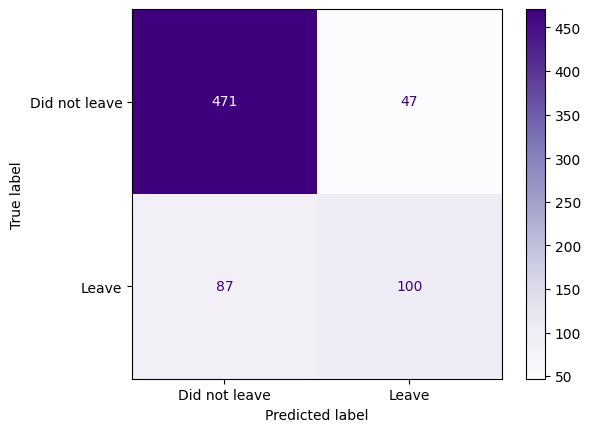

In [ ]:
y_pred_1 = clf_xgb.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1, 
                                      labels=clf_xgb.classes_, 
                                      normalize=None,
                                      display_labels=['Did not leave', 'Leave'],
                                      cmap='Purples')

The confusion matrix shows that 471 out of 518 people who left the company were correctly classified (and 47 were not). Among those who left, the model only predicted 87 of them (and missclassified 100). This is due to the imbalanced data: the model is biased to predict Non-leave. 

To solve this problem, we can use the parameter `scale_pos_weight`. This parameter is used to put a penalty when incorrectly predicting the minority class.

# 7. Hyperparameter tunning with Cross Validation and GridSearch()

XGBoost has a lot of *hyperparameters*, such as:
1. `max_depth`: the maximum depth of the trees.
2. `learning rate`: the learning rate by which the prediction of each tree is multiplied.
3. `gamma`: the parameter compared with the gain and used to decide whether a leave is prunned or not.
4. `reg_lambda`: the regularization parameter when calculating the similarity.
5. `scale_pos_weight`: used to set a penalty when incorrectly predicting the minority class.

In order to decide which values to use for each *hyperparameter*, we will use `GridSearch()`. Uncomment the following code to see how it works.

In [ ]:
# # If for any of the hyperparameters we get that the best result is the one
# # in the end of the range (e.g., 5 for max_depth),
# # we would continue exploring other candidates in that direction.

# param_grid = {
#     'max_depth': [5, 4, 3], 
#     'learning_rate': [0.5, 0.2, 0.01], 
#     'gamma': [1.0, 0.25, 0], 
#     'reg_lambda': [20.0, 10.0, 1.0],
#     'scale_pos_weight': [5, 3, 1]
# }

In [ ]:
# optimal_params = GridSearchCV(
#     estimator=xgb.XGBClassifier(
#               seed=42,                    
#               subsample=1,             # sample of the dataset to try with
#               colsample_bytree=0.9),   # number of variables to try with per try
#     param_grid=param_grid,
#     scoring='roc_auc',                 # model evaluation
#     verbose=2,                         # set to 2 to see the progress
#     n_jobs=10,                         
#     cv=3,                              # number of cross-validation sets
#     return_train_score=False           # parameter to return training scores
# )

In [ ]:
# optimal_params.fit(X_train,
#                    y_train,
#                    early_stopping_rounds=10,
#                    eval_metric='auc',
#                    eval_set=[(X_val, y_val)],
#                    verbose=True)

In [ ]:
# print(optimal_params.best_params_)

# 8. Building the Optimized XGBoost Model

Now we can build our definitive XGBoost model with the parameters the `GridSearch()` found. 

In [ ]:
%%capture
clf_xgb = xgb.XGBClassifier(
    seed=42,
    gamma=0.25,
    learning_rate=0.1,
    max_depth=4,
    reg_lambda=20.0,
    scale_pos_weight=5)

clf_xgb.fit(X_train,
            y_train,
            verbose=False,
            eval_metric='aucpr',
            early_stopping_rounds=10,
            eval_set=[(X_val, y_val)])

The following code makes predictions on the test set, calculates the confusion matrix and plots it. 

In [ ]:
y_pred_2 = clf_xgb.predict(X_test)

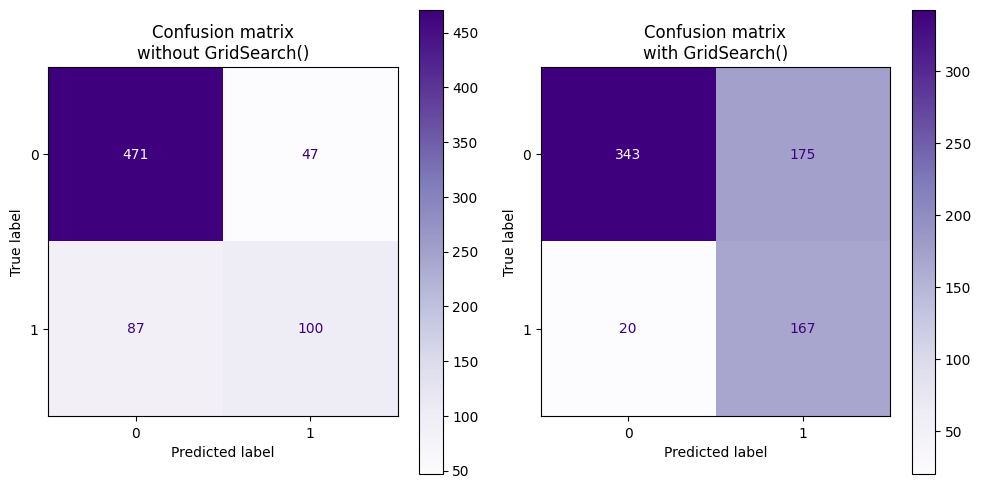

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot first confusion matrix
cm_1 = confusion_matrix(y_test, y_pred_1, labels=clf_xgb.classes_)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, 
                                display_labels=clf_xgb.classes_)
disp_1.plot(ax=axs[0], cmap='Purples')
axs[0].set_title('Confusion matrix\nwithout GridSearch()')

# plot second confusion matrix
cm_2 = confusion_matrix(y_test, y_pred_2, labels=clf_xgb.classes_)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, 
                                display_labels=clf_xgb.classes_)
disp_2.plot(ax=axs[1], cmap='Purples')
axs[1].set_title('Confusion matrix\nwith GridSearch()')

plt.tight_layout()
plt.show()

In [ ]:
# get precision, recall, and f1-score for class 1 (first model)
p_1, r_1, f1_1, _=precision_recall_fscore_support(y_test, y_pred_1, labels=[1])

# get precision, recall, and f1-score for class 1 (second model)
p_2, r_2, f1_2, _=precision_recall_fscore_support(y_test, y_pred_2, labels=[1])

In [ ]:
P_1, R_1, F1_1 = round(p_1[0]*100,2), round(r_1[0]*100,2), round(f1_1[0]*100,2)
P_2, R_2, F1_2 = round(p_2[0]*100,2), round(r_2[0]*100,2), round(f1_2[0]*100,2)

d = {'Without GridSearch()': [P_1, R_1, F1_1],
     'With GridSearch()': [P_2, R_2, F1_2],
     'Difference': [P_2-P_1, R_2-R_1, F1_2-F1_1]}
df_metrics = pd.DataFrame(data=d, index=['Precision', 'Recall', 'F1-score'])
df_metrics

,Without GridSearch(),With GridSearch(),Difference
Precision,68.03,48.83,-19.20
Recall,53.48,89.30,35.82
F1-score,59.88,63.14,3.26


Once we compare both models, we can see that the GridSearch allows to improve the recall (by 35.82 percentage points) but at the expense of reducing the precision (by -19.20 percentage points). By looking at the confusion matrix, we can observe that the model performs similarly to the previous one but is now less likely to predict the majority class. This can be due to the penalty parameter.

Therefore, an interesting experiment to run is train the same model without penalising the predictions of the majority class.

# 9. Hyperparameter tunning without penalising the predictions of the majority class

In [ ]:
clf_xgb = xgb.XGBClassifier(
    seed=42,
    eval_metric='aucpr',
    early_stopping_rounds=10,

    gamma=0.25,
    learning_rate=0.1,
    max_depth=4,
    reg_lambda=20.0)

clf_xgb.fit(X_train,
            y_train,
            verbose=False,
            eval_set=[(X_val, y_val)])

y_pred_3 = clf_xgb.predict(X_test)

# get precision, recall, and f1-score for class 1 (third model)
p_3, r_3, f1_3, _=precision_recall_fscore_support(y_test, y_pred_3, labels=[1])

P_3, R_3, F1_3 = round(p_3[0]*100,2), round(r_3[0]*100,2), round(f1_3[0]*100,2)

d = {'Without GridSearch()': [P_1, R_1, F1_1],
     'With GridSearch()': [P_2, R_2, F1_2],
     'Without penalty': [P_3, R_3, F1_3],
     'Difference Grid': [P_2-P_1, R_2-R_1, F1_2-F1_1], 
     'Difference Penalty': [P_3-P_1, R_3-R_1, F1_3-F1_1]}

df_metrics = pd.DataFrame(data=d, index=['Precision', 'Recall', 'F1-score'])
df_metrics

,Without GridSearch(),With GridSearch(),Without penalty,Difference Grid,Difference Penalty
Precision,68.03,48.83,71.43,-19.20,3.40
Recall,53.48,89.30,53.48,35.82,0.00
F1-score,59.88,63.14,61.16,3.26,1.28


Effectively, once we train the model with the same hyperparameters without the penalty, the resulting model performs virtually the same as the first one. The only difference is a small increase in the precision by 3.4 percentage points (from 68% to 71%).

# 10. Conclusion

XGBoost model has been shown to perform well when predicting the chunk rate of a customer. 

Three models have been trained here: an original model without hyperparameter tuning, a second model with hyperparameter tuning using a `GridSearch()` and a third model with hyperparameter tuning using a `GridSearch()` that does not set a penalty (`scale_pos_weight`) for predicting the majority class.

The results across the three models are quite satisfactory, and the model to use will depend on whether the goal of the user is to maximise precision or recall.

# 11. References

The present notebook has been inspired by Joshua Starmer. A similar process to the one showed here can be found at https://statquest.org/product/jupyter-notebook-xgboost-in-python/.